# Occupancy


Occupacny data is divided into three files, one for training and the others for testing. In train file, a column 'Occupancy' shows whether there are one or more people in a room (0 for not occupied, 1 for occupied). The occupancy has been measured every minutes and train file covers a week's worth of data.
So the goal is to predict whether or not a room is occupied based on environmental measures such as temperature, light, and so on. The dataset is from [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Occupancy+Detection+).  

At first I explore the data and then create some new features and finally make a prediction using Logistic Regression model. In this project, I concentrate on <span style="color:#FF0033">logical flow for producing new features</span> rather than select them by rote. 




### 1. Introduction
### 2. [Exploratory Data Analysis](#eda)
       
 -  2.1 [Missing value check](#missing)    
 -  2.2 [Features](#Features)
     - 2.2.1 [Occupancy](#Features)
     - 2.2.2 [Temperature](#Temperature)
     - 2.2.3 [Light](#Light) 
     - 2.2.4 [CO2](#CO2)
     - 2.2.5 [Humidity](#Humidity)
     - 2.2.6 [HumidityRatio](#HumidityRatio)
     
### 3. [Feature engineering](#fe)
 -  3.1 [Pearson correlation](#fe)
 -  3.2 [Outlier](#out)
 -  3.3 [Creating new features](#create)
     - 3.3.1 [CO2 x Temperature](#ct)
     - 3.3.2 [CO2 x Light](#cl)
     - 3.3.3 [Humidity x Temperature](#ht)
     - 3.3.4 [Dummy variables based on sequence - Temperature's dummy, CO2's dummy ](#dummy)
 
     
### 4. [Prediction](#prediction)
   



# 1. Introduction
## Load and check data

In [2]:
import numpy as np
import pandas as pd
from pandas import Series
import missingno as msno 
import statsmodels.api as sm

import matplotlib.pyplot as plt
#plt.style.use('ggplot')
%matplotlib inline

import seaborn as sns
sns.set(font_scale=2)
sns.set_style('whitegrid')

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
df_train = pd.read_csv('D:/dataset/occupancy_datatraining.csv')
df_test1 = pd.read_csv('D:/dataset/occupancy_datatest.csv')
df_test2 = pd.read_csv('D:/dataset/occupancy_datatest2.csv')

print("train_data:", df_train.shape)
print("test_data1:", df_test1.shape)
print("test_data2:", df_test2.shape)

train_data: (8143, 7)
test_data1: (2665, 7)
test_data2: (9752, 7)


In [4]:
df_train.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,2015-02-04 17:51,23.18,27.2720,426.0,721.25,0.004793,1
1,2015-02-04 17:51,23.15,27.2675,429.5,714.00,0.004783,1
2,2015-02-04 17:53,23.15,27.2450,426.0,713.50,0.004779,1
3,2015-02-04 17:54,23.15,27.2000,426.0,708.25,0.004772,1
4,2015-02-04 17:55,23.10,27.2000,426.0,704.50,0.004757,1


In [5]:
df_test2.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,2015-02-11 14:48,21.7600,31.133333,437.333333,1029.666667,0.005021,1
1,2015-02-11 14:49,21.7900,31.000000,437.333333,1000.000000,0.005009,1
2,2015-02-11 14:50,21.7675,31.122500,434.000000,1003.750000,0.005022,1
3,2015-02-11 14:51,21.7675,31.122500,439.000000,1009.500000,0.005022,1
4,2015-02-11 14:51,21.7900,31.133333,437.333333,1005.666667,0.005030,1


# 2. Exploratory Data Analysis
<a id="eda"></a>
## 2.1 Missing value check
<a id="missing"></a>
## Train data
There are 8143 rows and no missing values. All variables are continuous except 'date'.

column: date       	 Percent of NaN value:0.000000%
column: Temperature 	 Percent of NaN value:0.000000%
column: Humidity   	 Percent of NaN value:0.000000%
column: Light      	 Percent of NaN value:0.000000%
column: CO2        	 Percent of NaN value:0.000000%
column: HumidityRatio 	 Percent of NaN value:0.000000%
column: Occupancy  	 Percent of NaN value:0.000000%


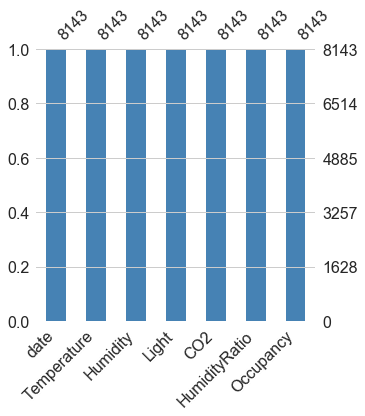

In [6]:
for col in df_train.columns:
    msg = 'column: {:<10} \t Percent of NaN value:{:2f}%'.format(col, 100*df_train[col].isnull().sum()/df_train.shape[0])
    print(msg)

msno.bar(df = df_train.iloc[:,:], figsize=(5,5), color='steelblue')

## Test data1 & Test data2
2665 rows in test1 and 9752 rows in test2. There are no missing values like train data.


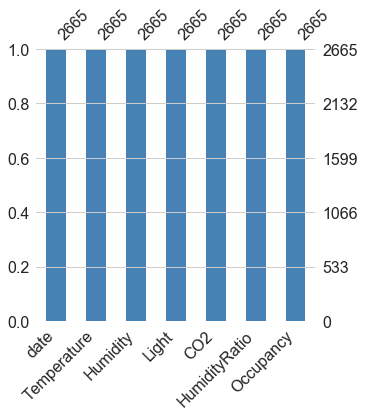

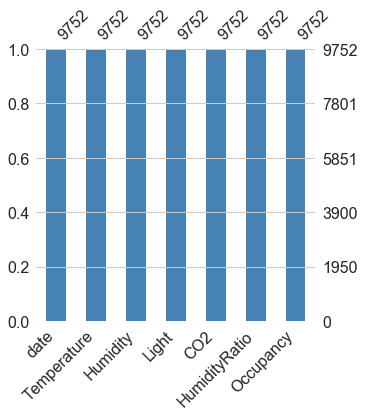

In [7]:
msno.bar(df = df_test1.iloc[:,:], figsize=(5,5), color='steelblue')
msno.bar(df = df_test2.iloc[:,:], figsize=(5,5), color='steelblue')

## 2.2   Features 
<a id="Features"></a>
## 2.2.1 Occupancy
This is the target feature for building our model. You might think there is an imbalance between 0 (not occupied) and 1 (occupied). But considering data are based on time series, It is acceptable.

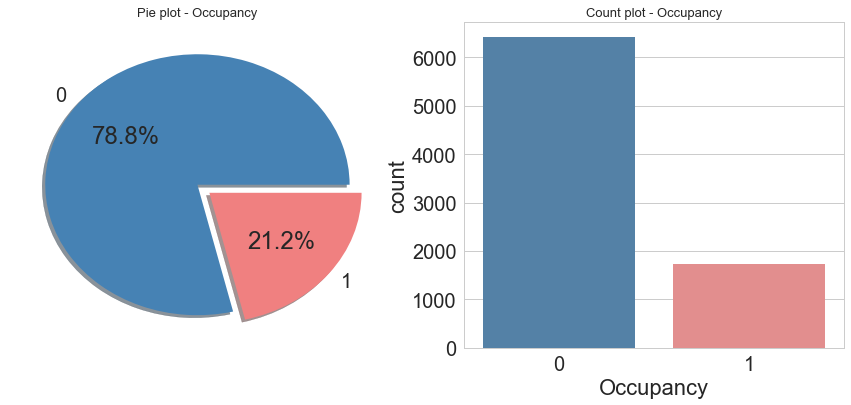

In [7]:
f, ax = plt.subplots(1, 2, figsize=(15, 6))

df_train['Occupancy'].value_counts().plot.pie(explode=[0, 0.1], autopct='%1.1f%%', ax=ax[0], shadow=True,colors=('steelblue','lightcoral'))
ax[0].set_title('Pie plot - Occupancy',fontsize=13)
ax[0].set_ylabel('') 

sns.countplot('Occupancy', data=df_train, ax=ax[1],  palette={0:'steelblue', 1:'lightcoral'})
ax[1].set_title('Count plot - Occupancy',fontsize=13)

plt.show()

## 2.2.2 Temperature
<a id="Temperature"></a>
It seems that there is a difference between a distribution of occupancy 0 and occupancy 1. So I think it is an important variable for predicting the target value.

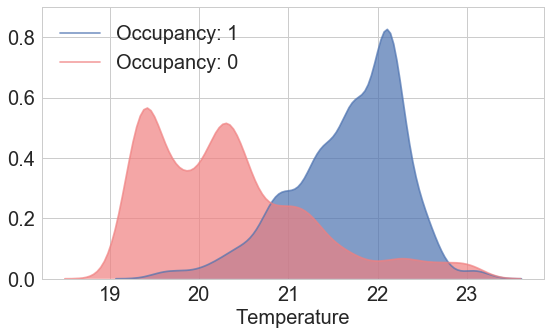

In [8]:
def kde_plot(df, feature, ylim):
    fig, ax = plt.subplots(1, 1, figsize=(9, 5))
    sns.kdeplot(df[df['Occupancy'] == 1][feature], shade=True, alpha=0.7, ax=ax) 
    sns.kdeplot(df[df['Occupancy'] == 0][feature], shade=True, alpha=0.7, ax=ax, color='lightcoral')
    
    plt.ylim(0,ylim)
    plt.xlabel(feature, fontsize=20)
    plt.legend(['Occupancy: 1', 'Occupancy: 0'])
    plt.show()    

kde_plot(df_train, 'Temperature', 0.9)

## Temperature with date
Here is time series plot of Temperature. The gray area indicates that a room is occupied and the white area is the opposite. Temperature generally goes up in the gray and down in the white. But although there is no one on February 7 and 8, It has a similar tendency. So I conclude that considering the time of gray area is daytime and the weather is winter, rising temperatures in this area are the effect of heater. Also the cause of a rise in the white area simply appears to be the effects of the sun.

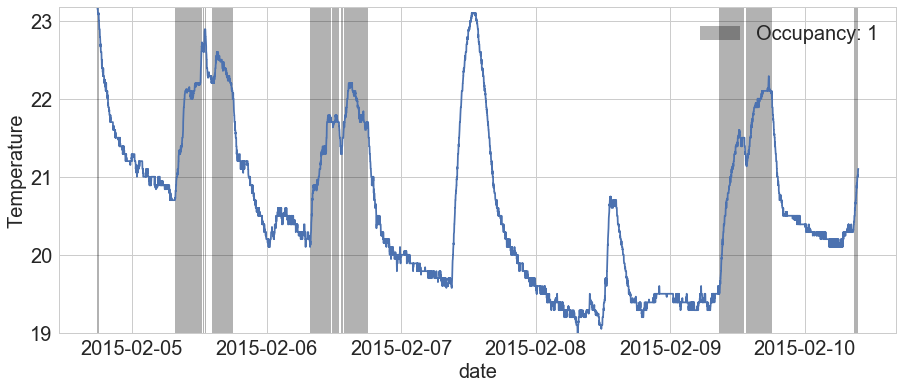

In [9]:
def date_plot(df, feature):
    
    from datetime import datetime
    fig, ax = plt.subplots(1,1, figsize=(15, 6))
    
    idx = pd.to_datetime(df['date'])
    ax.fill_between(idx.dt.to_pydatetime(), 0, 1, where=df['Occupancy'], alpha=0.3, transform=ax.get_xaxis_transform(), facecolor='black')
    
    plt.ylim(df[feature].min(),df[feature].max())
    plt.ylabel(feature, fontsize=20)
    plt.xlabel('date', fontsize=20)
    plt.legend(['Occupancy: 1', 'Occupancy: 0'], loc='best')
    plt.plot(idx, df[feature])
    
date_plot(df_train,'Temperature')

## 2.2.3 Light
<a id="Light"></a>
Like temperature, there is a big difference between two distributions. So I think it is also very important. 

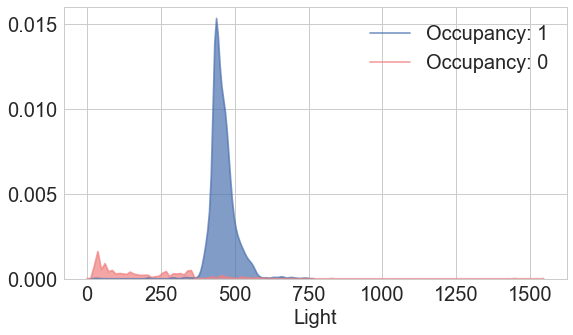

In [10]:
kde_plot(df_train,'Light',0.016)

## Light with date
Light has periodicity. In the gray area it has large value. On the other hand in the white it has almost zero except for two days (2/7 - 2/8).  When looking at these two days, it is weekend and therefore the part of having values would be
absolutely caused by the effect of the sun. Also I think there are outliers (greater than 800) so I remove them after. As for the other white area, given that it's early to go to work (the time is before 7 a.m), the switch in the room would be off. Overall, Light feature shows clear differences between two states (0 or 1).

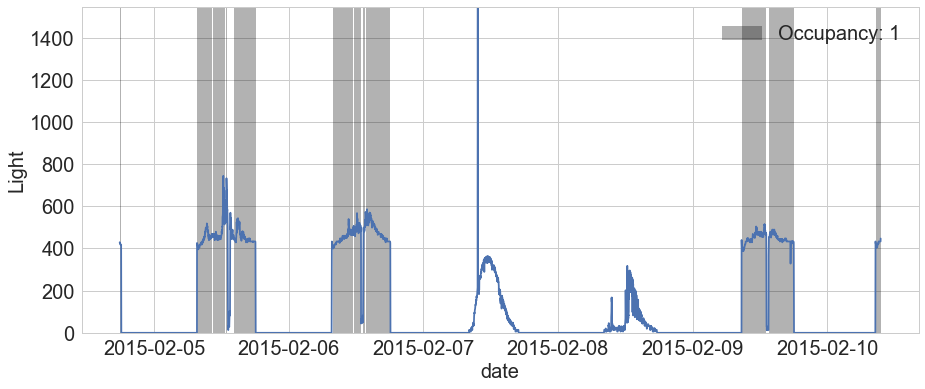

In [11]:
date_plot(df_train,'Light')

## 2.2.4 CO2
<a id="CO2"></a>
CO2 shows a clear difference between two distributions.

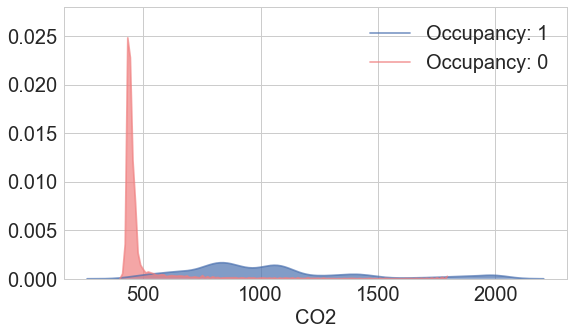

In [12]:
kde_plot(df_train,'CO2',0.028)

## CO2 with date
CO2 shows big differences between two states (0 or 1). It is directly related to whether or not there are people in a room. So unlike Temperature and Light, CO2 has small values in the white area.

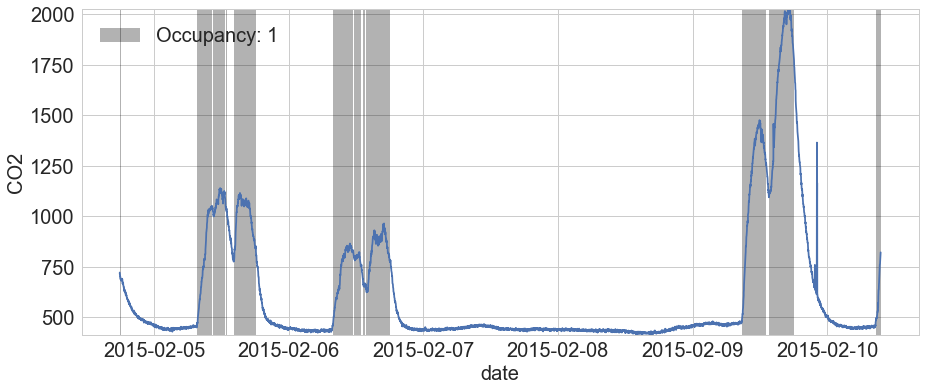

In [13]:
date_plot(df_train,'CO2')

## 2.2.5 Humidity
<a id="Humidity"></a>
It seems that two distributions are almost indistinguishable. 

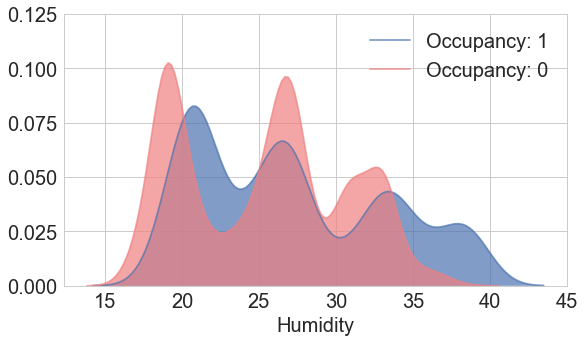

In [14]:
kde_plot(df_train,'Humidity',0.125)

## Humidity with date
Humidity has similar trends to Temperature. But in the weekend of the white area (2/7 - 2/8), they are complete opposites. In other words, when temperature increases humidity decreases. It's a natural phenomenon. As for the gray area, they are almost the same. So I think there's a possibility that people run a humidifier to prevent drying in winter.  

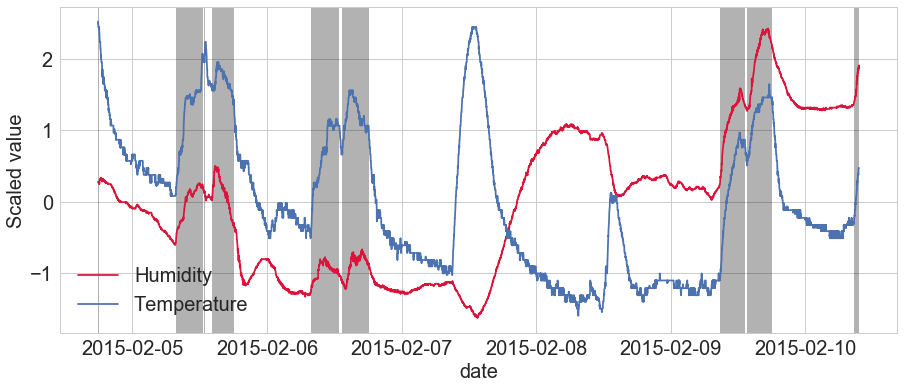

In [15]:
def comparison_plot(df, feature1, feature2):
    
    from sklearn.preprocessing import scale
    scale1 = scale(df[feature1])
    scale2 = scale(df[feature2])

    fig, ax = plt.subplots(1,1, figsize=(15, 6))

    idx = pd.to_datetime(df['date'])
    ax.fill_between(idx.dt.to_pydatetime(), 0, 1, where=df['Occupancy'], alpha=0.3, transform=ax.get_xaxis_transform(), facecolor='black')

    plt.ylabel('Scaled value',fontsize=20)
    plt.xlabel('date',fontsize=20)
    plt.plot(idx, scale2 ,label= feature2, color='crimson')
    plt.plot(idx, scale1 ,label= feature1)
    plt.legend()
    plt.show()

comparison_plot(df_train, 'Temperature', 'Humidity')    

## 2.2.6 HumidityRatio
<a id="HumidityRatio"></a>
Like Humidity, two distributions aren't distinguishable. 

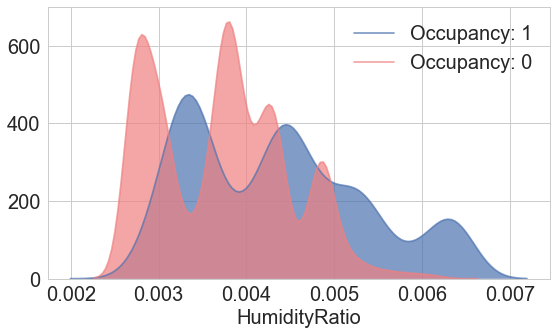

In [16]:
kde_plot(df_train,'HumidityRatio',700)

## HumidityRatio with date
This is almost the same as Humidity plot.

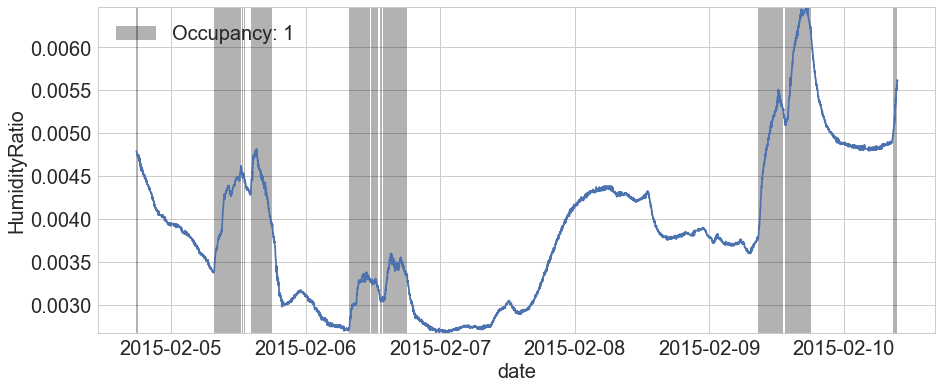

In [17]:
date_plot(df_train,'HumidityRatio')

# 3. Feature engineering
<a id="fe"></a>
## 3.1 Pearson correlation
As previously confirmed, Humidity and HumidityRatio have similar properties. The correlation of these two features is 0.96. So I delete one of them, HumidityRatio, because I think the units of Humidity is stable.  

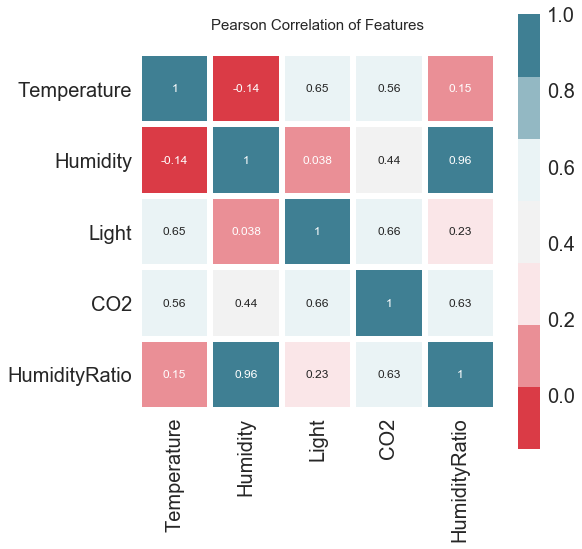

In [18]:
heatmap_data = df_train[['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio']] 

plt.figure(figsize=(8, 8))
plt.title('Pearson Correlation of Features', y=1.05, size=15)

sns.heatmap(heatmap_data.astype(float).corr(), linewidths=5, vmax=1,
           square=True, cmap=sns.diverging_palette(10, 220, sep=80, n=7), linecolor='white', annot=True, annot_kws={"size": 12})

I drop HumidityRatio. 

In [19]:
df_train[['Humidity','HumidityRatio']].astype(float).corr()

,Humidity,HumidityRatio
Humidity,1.000000,0.955198
HumidityRatio,0.955198,1.000000


In [20]:
df_train.drop(['HumidityRatio'], axis=1, inplace=True)
df_test1.drop(['HumidityRatio'], axis=1, inplace=True)
df_test2.drop(['HumidityRatio'], axis=1, inplace=True)

## 3.2 Outlier
<a id="out"></a>
As previously confirmed, there are some outliers in Light. These values make peak.  

Text(0.5,0,'Index')

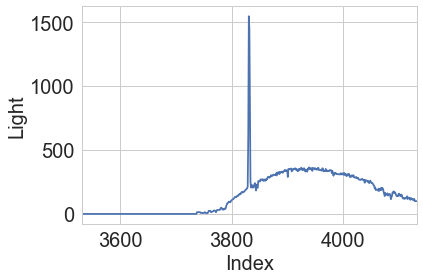

In [21]:
start = df_train[df_train['Light']>=800].index[0]
end =  df_train[df_train['Light']>=800].index[2]

df_train[start-300:end+300]['Light'].plot()
plt.ylabel('Light',fontsize=20)
plt.xlabel('Index',fontsize=20)

I delete values which is greater than 800 and then reset index.

In [22]:
df_train[df_train['Light']>800]

,date,Temperature,Humidity,Light,CO2,Occupancy
3831,2015-02-07 9:42,20.700,18.890000,1546.333333,455.333333,0
3832,2015-02-07 9:42,20.745,18.890000,1451.750000,453.000000,0
3833,2015-02-07 9:43,20.760,18.856667,829.000000,452.666667,0


In [23]:
df_train.drop(df_train[df_train['Light']>800].index, axis=0, inplace=True)
print(df_train.shape)

(8140, 6)


In [24]:
df_train = df_train.reset_index(drop=True)
df_test1 = df_test1.reset_index(drop=True)
df_test2 = df_test2.reset_index(drop=True)

## 3.3 Creating new features 
<a id="create"></a>
## 3.3.1 CO2 x Temperature
<a id="ct"></a>
On the basis of the above results, I will create some new features. First of all, to predict accurate results I have to control Temperature, Light and Humidity in the situation where there is no one (white area). So I use 'CO2'  because this makes a big difference between occupancy=0 and 1. As a result,  I create a new feature, 'CO2 x Temperature'.  By doing this, I can control Temperature.

In [25]:
df_train['CO2*Temperature'] = df_train['CO2']*df_train['Temperature']
df_test1['CO2*Temperature'] = df_test1['CO2']*df_test1['Temperature']
df_test2['CO2*Temperature'] = df_test2['CO2']*df_test2['Temperature']

Let's see a red line below. On 7 and 8 Feb, a red line is almost zero. In other words, CO2 makes Temperature have smaller values because CO2 has almost zero in this area. On the other hand in the gray area, it is similar to or greater than Temperature.

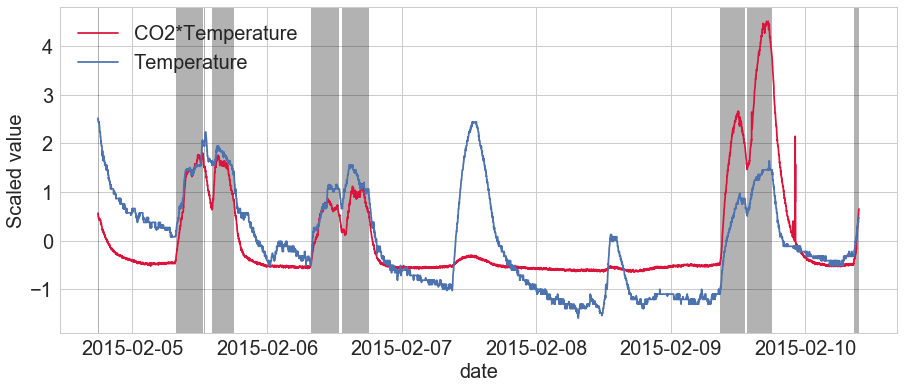

In [26]:
comparison_plot(df_train, 'Temperature', 'CO2*Temperature')    

## 3.3.2  CO2 x Light
<a id="cl"></a>
In the same way, CO2 can control the effect of Light.

In [27]:
df_train['CO2*Light'] = df_train['CO2']*df_train['Light']
df_test1['CO2*Light'] = df_test1['CO2']*df_test1['Light']
df_test2['CO2*Light'] = df_test2['CO2']*df_test2['Light']

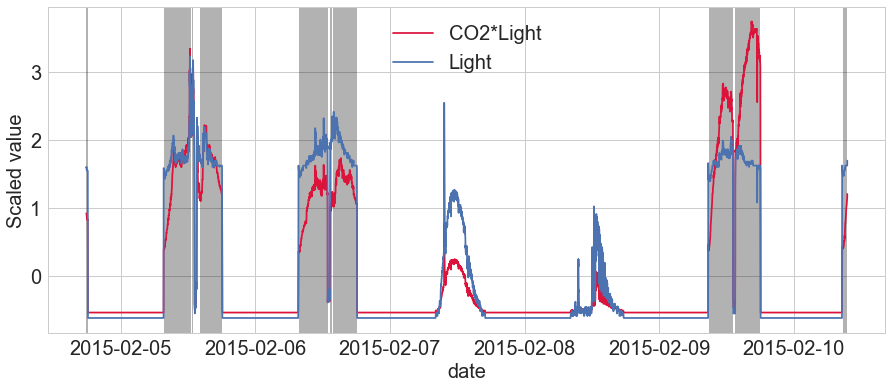

In [28]:
comparison_plot(df_train,'Light','CO2*Light')  

## 3.3.3  Humidity x Temperature
<a id="ht"></a>
I create 'Humidity x Temperature' based on natural phenomenon that we already confirmed in Humidity plot. 

In [29]:
df_train['Humidity*Temperature'] = df_train['Humidity']*df_train['Temperature']
df_test1['Humidity*Temperature'] = df_test1['Humidity']*df_test1['Temperature']
df_test2['Humidity*Temperature'] = df_test2['Humidity']*df_test2['Temperature']

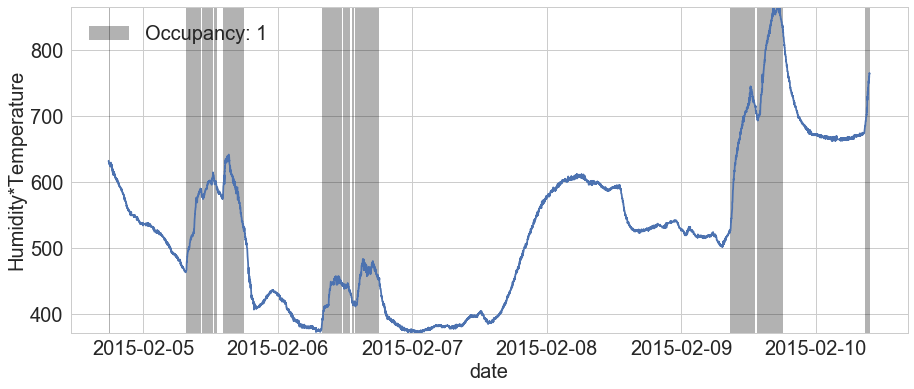

In [30]:
date_plot(df_train,'Humidity*Temperature')

## 3.3.4 Dummy variable based on sequence   
<a id="dummy"></a>
I would like to <span style="color:#006699">highlight</span>  this part. I find out that unlike Light, Temperature has countinuous values. In ohter words when everyone turns off the switch and then is out, Light changes immediately (from some value to zero). But Temperature doesn't. So it can have the same values in both cases (Occupancy=0 and Occupancy=1). As a result, the machine (our model) can't distinguish these values. Let's see <span style="color:#FF0033">the red box</span>  below. The value of the gray area is the same as that of the white.


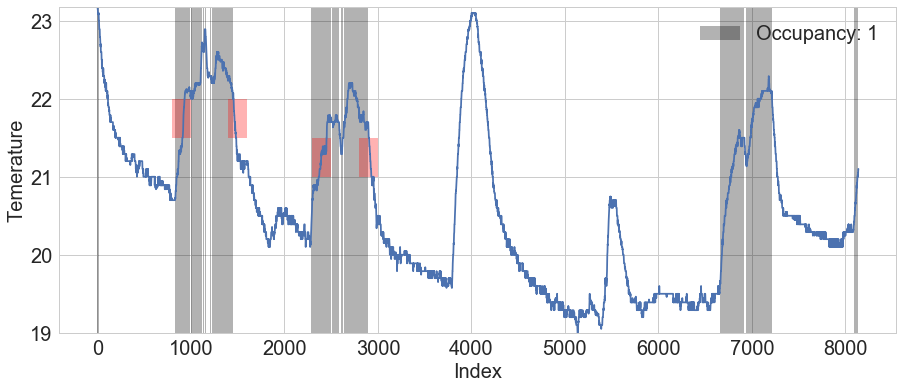

In [31]:
from datetime import datetime

fig, ax = plt.subplots(1,1, figsize=(15, 6))
idx = range(1,len(df_train)+1)

ax.fill_between(idx, 0, 1, where=df_train['Occupancy'], alpha=0.3, transform=ax.get_xaxis_transform(), facecolor='black')

ax.broken_barh([(800,200)], (21.5, 0.5), facecolor='red',alpha=0.3)
ax.broken_barh([(1400,200)], (21.5, 0.5), facecolor='red',alpha=0.3)

ax.broken_barh([(2300,200)], (21, 0.5), facecolor='red',alpha=0.3)
ax.broken_barh([(2800,200)], (21, 0.5), facecolor='red',alpha=0.3)

plt.ylim(df_train['Temperature'].min(),df_train['Temperature'].max())
plt.ylabel('Temerature',fontsize=20)
plt.xlabel('Index',fontsize=20)
plt.legend(['Occupancy: 1'])
plt.plot(idx, df_train['Temperature'])


## Temperature dummy
To make our model distinguish these ambiguous values, I create dummy variables. Let the current point be t. If earlier five-time-points   (t-1,...,t-5) have increased monotonically, dummy variable of this current point t is set to 1. By doing this, our model can know well where this point belong (gray or white). 

In [32]:
def create_dummy(train, test1, test2, dummy, feature):
    
    # Create dummy variable
    df_train[dummy] = np.repeat(0,len(df_train))
    df_test1[dummy] = np.repeat(0,len(df_test1))
    df_test2[dummy] = np.repeat(0,len(df_test2))
    
    # Set initial value
    # train data 
    init_t1 = train[feature][0]
    init_t2 = train[feature][1]
    init_t3 = train[feature][2]
    init_t4 = train[feature][3]
    init_t5 = train[feature][4]
    
    # test1 data
    init_test1 = test1[feature][0]
    init_test1 = test1[feature][1]
    init_test1 = test1[feature][2]
    init_test1 = test1[feature][3]
    init_test1 = test1[feature][4]
    
    # test2 data
    init_test2 = test2[feature][0]
    init_test2 = test2[feature][1]
    init_test2 = test2[feature][2]
    init_test2 = test2[feature][3]
    init_test2 = test2[feature][4]
    
    # Fill dummy value
    for i in range(5,len(df_train)):
        
        if init_t1 <= init_t2 and init_t2 <= init_t3 and init_t3 <= init_t4 and init_t4 <= init_t5:
            df_train[dummy][i] = 1
    
        init_t1 = train[feature][i-4]
        init_t2 = train[feature][i-3]
        init_t3 = train[feature][i-2]
        init_t4 = train[feature][i-1]
        init_t5 = train[feature][i]
    
    for i in range(5,len(df_test1)):
        
        if init_test1 <= init_test1 and init_test1 <= init_test1 and init_test1 <= init_test1 and init_test1 <= init_test1:
            df_test1[dummy][i] = 1
    
        init_test1 = test1[feature][i-4]
        init_test1 = test1[feature][i-3]
        init_test1 = test1[feature][i-2]
        init_test1 = test1[feature][i-1]
        init_test1 = test1[feature][i]
    
    for i in range(5,len(df_test2)):
        
        if init_test2 <= init_test2 and init_test2 <= init_test2 and init_test2 <= init_test2 and init_test2 <= init_test2:
            df_test2[dummy][i] = 1
            
        init_test2 = test2[feature][i-4]
        init_test2 = test2[feature][i-3]
        init_test2 = test2[feature][i-2]
        init_test2 = test2[feature][i-1]
        init_test2 = test2[feature][i]
    
create_dummy(df_train, df_test1, df_test2, 'Tdummy', 'Temperature')    

Here are the results. Temperature's dummy variable (Tdummy) is created.

In [33]:
df_train.head()

,date,Temperature,Humidity,Light,CO2,Occupancy,CO2*Temperature,CO2*Light,Humidity*Temperature,Tdummy
0,2015-02-04 17:51,23.18,27.2720,426.0,721.25,1,16718.5750,307252.5,632.164960,0
1,2015-02-04 17:51,23.15,27.2675,429.5,714.00,1,16529.1000,306663.0,631.242625,0
2,2015-02-04 17:53,23.15,27.2450,426.0,713.50,1,16517.5250,303951.0,630.721750,0
3,2015-02-04 17:54,23.15,27.2000,426.0,708.25,1,16395.9875,301714.5,629.680000,0
4,2015-02-04 17:55,23.10,27.2000,426.0,704.50,1,16273.9500,300117.0,628.320000,0


For your clear understanding, I draw Tdummy plot about some rows of data.    

Text(0,0.5,'Tdummy')

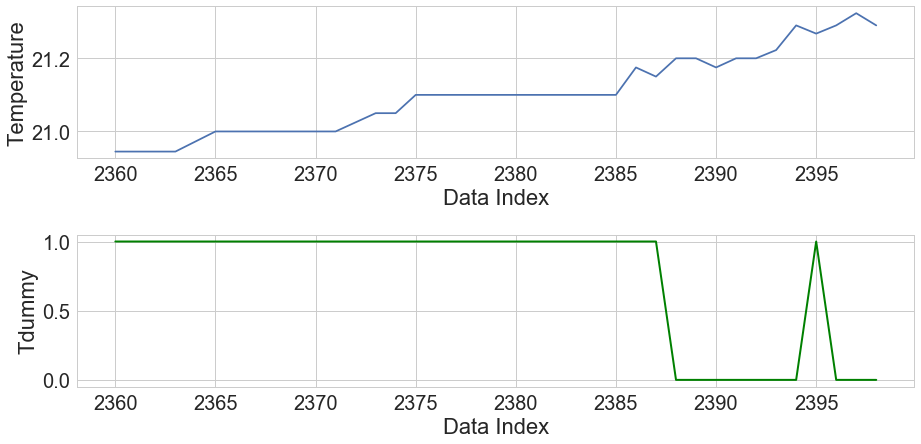

In [34]:
f,(ax1,ax2) = plt.subplots(2,1,figsize=(15,7))
plt.subplots_adjust(hspace=0.5)

ax1.plot(df_train['Temperature'][2360:2399])
ax1.set_xlabel("Data Index")
ax1.set_ylabel("Temperature")

ax2.plot(df_train['Tdummy'][2360:2399], linewidth=2, color='green')
ax2.set_xlabel("Data Index")
ax2.set_ylabel("Tdummy")

## CO2 dummy
In the same way as Tdummy, Cdummy is produced.

In [35]:
create_dummy(df_train, df_test1, df_test2, 'Cdummy', 'CO2')    

In [36]:
df_train.head()

,date,Temperature,Humidity,Light,CO2,Occupancy,CO2*Temperature,CO2*Light,Humidity*Temperature,Tdummy,Cdummy
0,2015-02-04 17:51,23.18,27.2720,426.0,721.25,1,16718.5750,307252.5,632.164960,0,0
1,2015-02-04 17:51,23.15,27.2675,429.5,714.00,1,16529.1000,306663.0,631.242625,0,0
2,2015-02-04 17:53,23.15,27.2450,426.0,713.50,1,16517.5250,303951.0,630.721750,0,0
3,2015-02-04 17:54,23.15,27.2000,426.0,708.25,1,16395.9875,301714.5,629.680000,0,0
4,2015-02-04 17:55,23.10,27.2000,426.0,704.50,1,16273.9500,300117.0,628.320000,0,0


Here are plots for comparison.

Text(0,0.5,'Cdummy')

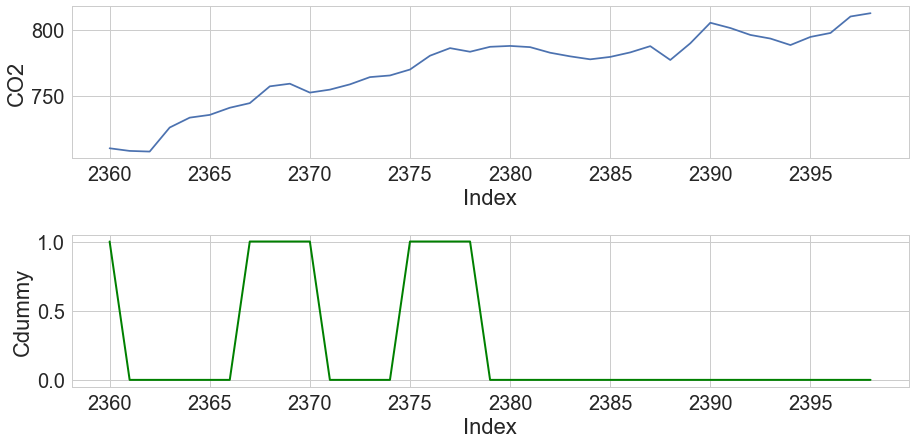

In [37]:
f,(ax1,ax2) = plt.subplots(2,1,figsize=(15,7))
plt.subplots_adjust(hspace=0.5)

ax1.plot(df_train['CO2'][2360:2399])
ax1.set_xlabel("Index")
ax1.set_ylabel("CO2")

ax2.plot(df_train['Cdummy'][2360:2399], linewidth=2, color='green')
ax2.set_xlabel("Index")
ax2.set_ylabel("Cdummy")


# 4. Prediction
<a id="prediction"></a>
## 4.1 Building the model 
Now, I builid the model for prediction based on above features. 

In [38]:
import statsmodels.api as sm
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

## Train data  / Test data
I prepare train and test data.

In [39]:
# Data with feature engineering
train = df_train[['Temperature', 'Humidity', 'Light', 'CO2', 'CO2*Temperature', 'CO2*Light', 'Humidity*Temperature', 'Tdummy', 'Cdummy']]
train_y = df_train['Occupancy']

# Original data
train_o =  df_train[['Temperature', 'Humidity', 'Light', 'CO2']]
train_o_y = df_train['Occupancy']

# Test data
test1 = df_test1[['Temperature', 'Humidity', 'Light', 'CO2', 'CO2*Temperature', 'CO2*Light', 'Humidity*Temperature', 'Tdummy', 'Cdummy']]
test1_y =  df_test1['Occupancy']

test2 = df_test2[['Temperature', 'Humidity', 'Light', 'CO2', 'CO2*Temperature', 'CO2*Light', 'Humidity*Temperature', 'Tdummy', 'Cdummy']]
test2_y =  df_test2['Occupancy']


## Logistic Regression
Because this problem is binary classification, I use Logistic Regression for prediction. Also I fit the model with original data to make a comparison with my model. The AIC and BIC of the model with feature engineering are lower than the model whit the original data.

In [40]:
# Model with feature engineering
model = sm.Logit.from_formula("Occupancy ~ Temperature + Light + CO2 + Humidity + CO2*Temperature + CO2*Light + Humidity*Temperature + Tdummy + Cdummy", df_train)
result = model.fit(disp=0)
#print(result_n.summary())

# Model with original data 
model_o = sm.Logit.from_formula("Occupancy ~ Temperature + Light + CO2 + Humidity", df_train)
result_o = model_o.fit(disp=0)
#print(result_o.summary())

# AIC & BIC
print("Model with original data- AIC: {} BIC: {}".format(round(result_o.aic,2),round(result_o.bic,2) ))
print("Model with feature engineering- AIC: {} BIC: {}".format(round(result.aic,2),round(result.bic,2) ))


Model with original data- AIC: 849.78 BIC: 884.81
Model with feature engineering- AIC: 770.7 BIC: 840.74


## Feature importance
You can see the feature importance of each input variable below. I compute this using the absolute value of parameter's coefficient. Dummy variables are at the top. It means that the model treat these variables importantly.

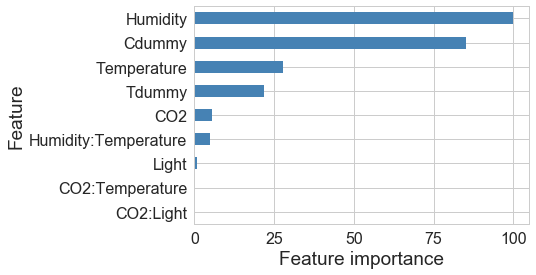

In [41]:
# feature_importance of model with feature engineering
feature_importance = abs(result.params)
feature_importance = 100.0 * (feature_importance / feature_importance.max())
feature_importance[1:].sort_values(ascending=True).plot.barh(color='steelblue',fontsize=16)
plt.xlabel('Feature importance', fontsize=19)
plt.ylabel('Feature',fontsize=19)
plt.show()


## 4.2  Prediction
## Model with feature engineering
I assessed the performance of prediction model using accuracy, the number of correct predictions from all predictions made. Test1 is better fitted than Test2. 

In [42]:
from sklearn.metrics import accuracy_score

# Train data
pre_train = result.predict(train)
pre0 = np.repeat(0,len(train))

for i in range(0,len(train)):
    if pre_train[i] >0.5:
        pre0[i] = 1
print('Train- Num of samples: {}  Accuracy: {:.2f}%'.format(train.shape[0], 100*accuracy_score(pre0, train_y)))
 
# Test1 data
pre_test1 = result.predict(test1)
pre1 = np.repeat(0,len(test1))

for i in range(0,len(test1)):
    if pre_test1[i] >0.5:
        pre1[i] = 1
print('Test1- Num of samples: {}  Accuracy: {:.2f}%'.format(test1.shape[0], 100*accuracy_score(pre1, test1_y)))
 
# Test2 data
pre_test2 = result.predict(test2)
pre2 = np.repeat(0,len(test2))

for i in range(0,len(test2)):
    if pre_test2[i] >0.5:
        pre2[i] = 1
print('Test2- Num of samples: {}  Accuracy: {:.2f}%'.format(test2.shape[0], 100 * accuracy_score(pre2, test2_y)))


Train- Num of samples: 8140  Accuracy: 98.61%
Test1- Num of samples: 2665  Accuracy: 97.19%
Test2- Num of samples: 9752  Accuracy: 91.65%
